In [1]:
import os
from IPython.display import Audio, HTML, Image, display
import math
import numpy as np


import pandas as pd
from tqdm.notebook import tqdm

import torch
import torchaudio
import copy
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
from torch.autograd import Variable
from torchmetrics.text.wer import WordErrorRate
from torchmetrics.text.cer import CharErrorRate

import nemo.collections.asr as nemo_asr
import sentencepiece as spm

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import datasetload
from utils import mainf, mainf_entropy
from evaluation import draw_reliability_graph, plot_histograms


In [2]:
import yaml

with open("config.yaml", "r") as file:
    config = yaml.safe_load(file)

input_data = config["input_data"]
asr_model = config["asr_model"]
spm_model_path = config["spm_model_path"]
DEVICE = config["DEVICE"]
TEST_BS = config["TEST_BS"]
audio_root = config["audio_root"]


In [3]:
df1 = pd.read_json(input_data, lines=True)

In [4]:
asr_model = nemo_asr.models.EncDecCTCModel.restore_from(restore_path=asr_model)


[NeMo I 2025-08-17 11:33:39 mixins:184] Tokenizer SentencePieceTokenizer initialized with 128 tokens


[NeMo W 2025-08-17 11:33:39 modelPT:181] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /data/Librispeech_SP_Tarred/tarred_audio_manifest.json
    sample_rate: 16000
    batch_size: 32
    shuffle: true
    num_workers: 8
    pin_memory: true
    use_start_end_token: false
    trim_silence: false
    max_duration: 16.7
    min_duration: 0.1
    shuffle_n: 2048
    is_tarred: true
    tarred_audio_filepaths: /data/Librispeech_SP_Tarred/audio__OP_0..511_CL_.tar
    
[NeMo W 2025-08-17 11:33:39 modelPT:188] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    manifest_filepath:
    - /manifests/librispeech/librivox-dev-other.json
    - /manife

[NeMo I 2025-08-17 11:33:39 features:306] PADDING: 0
[NeMo I 2025-08-17 11:33:40 save_restore_connector:282] Model EncDecCTCModelBPE was successfully restored from /home/thishyan/interspeech-2025/stt_en_conformer_ctc_small_ls.nemo.


In [5]:
asr_model.freeze() # inference mode
asr_model = asr_model.to(DEVICE) # transfer model to device

In [6]:
print(asr_model.decoder.vocabulary)

blank = len(asr_model.decoder.vocabulary)
unkwn = 0
vocab = copy.deepcopy(asr_model.decoder.vocabulary)
vocab.append('@') #For blank character

['<unk>', 'e', 's', '▁', 't', 'a', 'o', 'i', '▁the', 'd', 'l', 'n', '▁a', 'm', 'y', 'u', '▁s', 'p', 'ed', 'c', '▁and', 're', '▁to', '▁of', 'r', 'w', 'ing', '▁w', 'h', '▁p', '▁c', 'er', 'f', 'k', 'ar', '▁in', '▁f', '▁b', 'g', 'an', 'in', '▁i', 'en', '▁he', 'le', '▁g', 'or', 'll', 'b', '▁be', 'ro', 'st', 'on', '▁d', 'v', 'ly', 'ce', 'ur', 'es', '▁that', '▁o', 'us', '▁was', '▁it', '▁th', 've', 'ch', 'un', 'al', '▁t', '▁ma', 'ri', '▁you', '▁on', 'ver', 'ent', '▁for', '▁re', 'ra', "'", '▁his', 'ir', 'ter', '▁with', '▁her', 'it', 'th', '▁mo', '▁me', '▁ha', '▁e', '▁as', 'tion', '▁had', '▁not', '▁no', '▁do', 'ther', '▁but', '▁st', '▁she', '▁is', 'igh', '▁ho', '▁lo', 'ng', '▁him', '▁an', 'ck', 'j', 'ugh', '▁de', '▁li', '▁mi', '▁la', '▁my', '▁con', '▁have', '▁this', '▁which', 'q', '▁up', '▁said', '▁from', '▁who', '▁ex', 'x', 'z']


In [7]:
sp = spm.SentencePieceProcessor()
sp.load(spm_model_path)

True

In [8]:
input_testset = datasetload.inputDataset(df1, audio_root)

input_testloader = torch.utils.data.DataLoader(input_testset, batch_size = TEST_BS, shuffle = True, 
                                          collate_fn = datasetload.collate_batch_input, drop_last=True, 
                                          num_workers=4, pin_memory=True)

## Softmax 

In [9]:
targets_with_confidence = []
correct_marks = []
actual_score_all = [] 
except_count = 0
for batch in tqdm(input_testloader):
    # try:
    # references, HYP, word_ops_list, softmax_score = test_validate(batch, asr_model, DEVICE, TEST_BS, vocab)
    # except:
    #     except_count += 1
    empty = False
    references, HYP, word_ops_list, softmax_score = mainf(batch, asr_model, DEVICE, TEST_BS, temperature = 1.0)

    for i in range(len(HYP)):
        if HYP[i] == '':
            empty = True
    target_temp = []
    correct_temp = []
    if empty == True:
        continue
    for i in range(len(HYP)):
        words = HYP[i].split()
        j = 0
        for word in words:
            target_temp.append((word, softmax_score[i][j]))
            j+=1
        targets_with_confidence.append(target_temp)
        for k in range(len(word_ops_list[i])):
            if word_ops_list[i][k] == 'D':
                continue
            if word_ops_list[i][k] == 'C':
                correct_temp.append(1)
            else:
                correct_temp.append(0)
        correct_marks.append(correct_temp)
        actual_score_all.append(correct_temp)

print("exception count:", except_count)

  0%|          | 0/2620 [00:00<?, ?it/s]

exception count: 0


In [10]:
y_true, y_score = np.array(
    [[f, p[1]] for cm, twc in zip(correct_marks, targets_with_confidence) for f, p in zip(cm, twc)]
).T

mask_correct = y_true == 1
y_score_correct = y_score[mask_correct]
y_score_incorrect = y_score[~mask_correct]

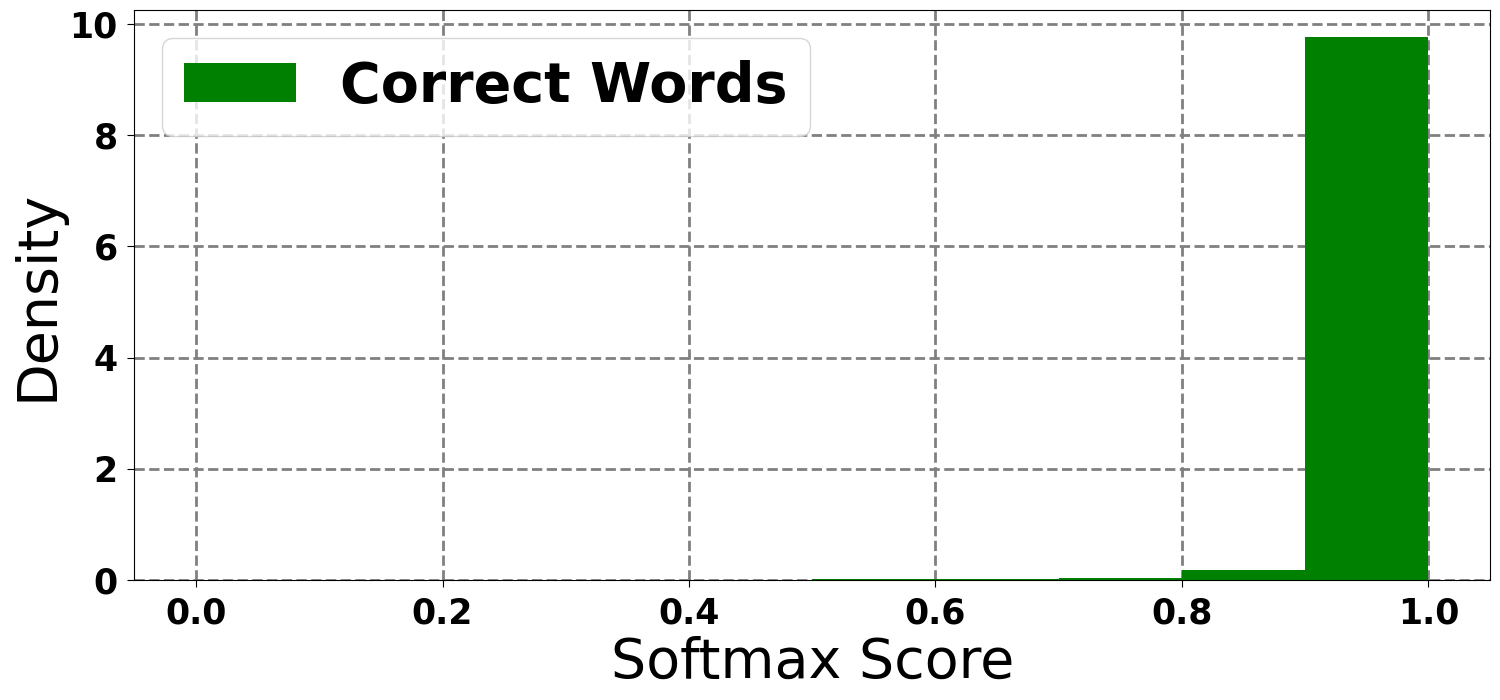

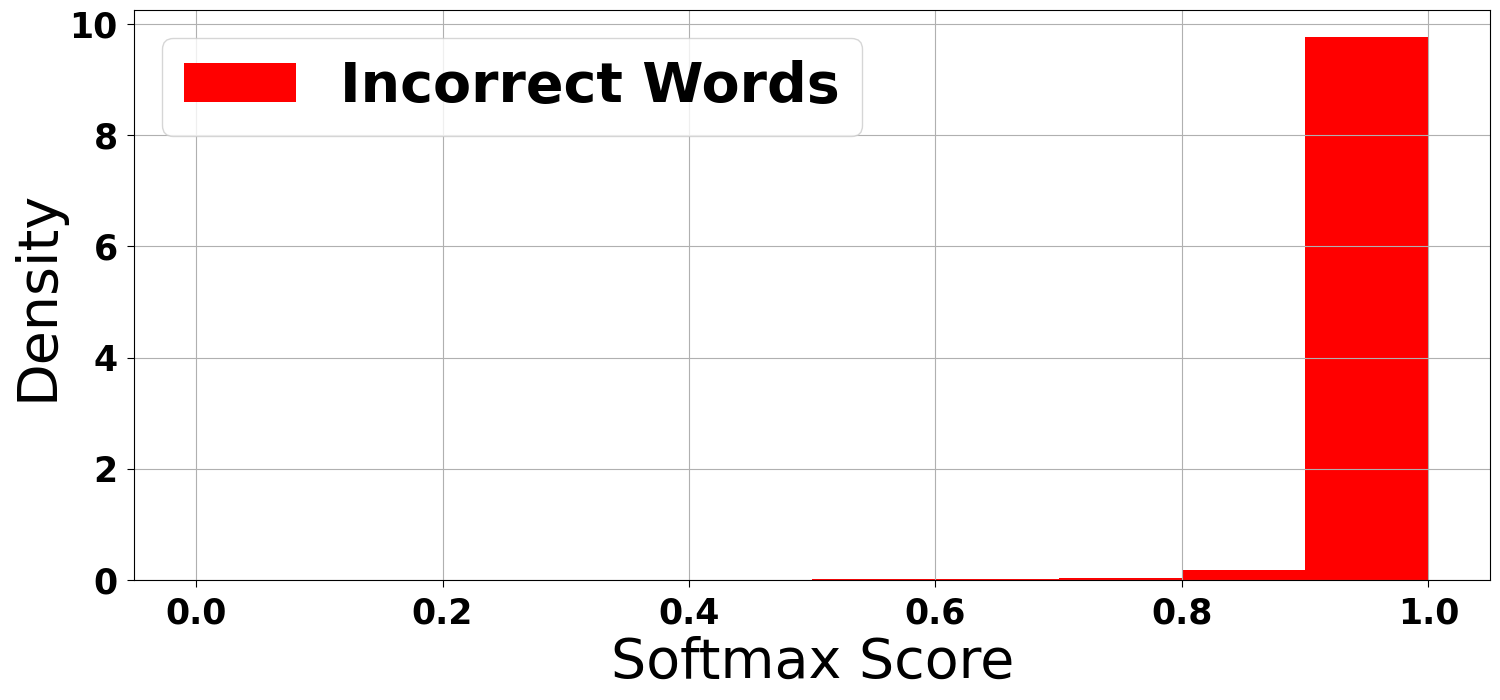

In [11]:
plot_histograms(y_score_correct, y_score_correct, x_label_name="Softmax Score")

In [12]:
p = []

actual_score_all_one_list = []
for i in range(len(correct_marks)):
    
    for j in range(len(correct_marks[i])):
        p.append(targets_with_confidence[i][j][1])
        actual_score_all_one_list.append(actual_score_all[i][j])

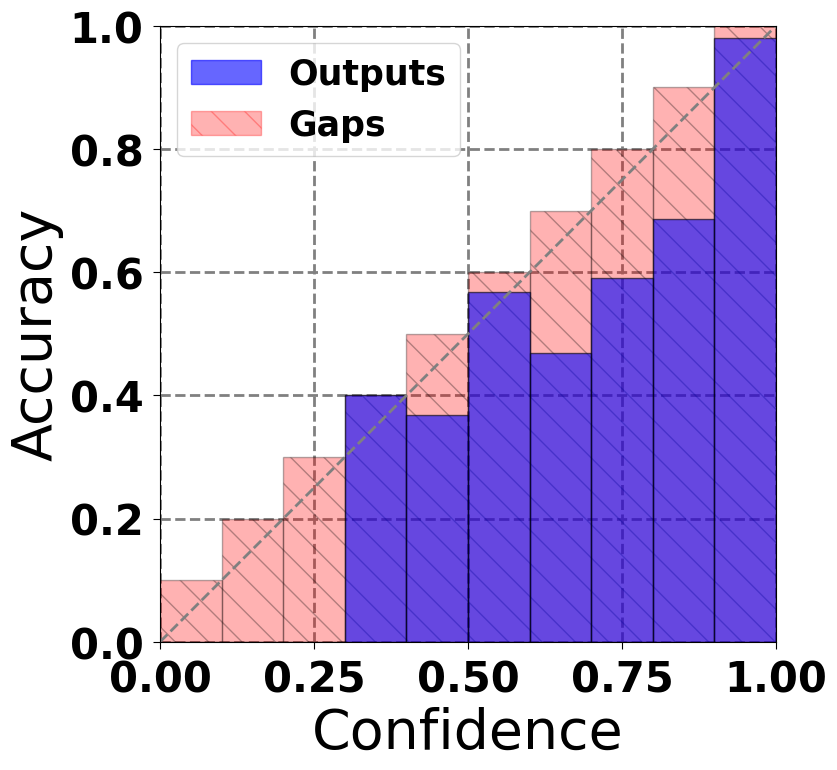

In [13]:
ece, mce = draw_reliability_graph(p, actual_score_all_one_list)

## Temperature Scaled softmax scores

In [14]:
targets_with_confidence = []
correct_marks = []
actual_score_all = [] 
except_count = 0
for batch in tqdm(input_testloader):
    # try:
    # references, HYP, word_ops_list, softmax_score = test_validate(batch, asr_model, DEVICE, TEST_BS, vocab)
    # except:
    #     except_count += 1
    empty = False
    references, HYP, word_ops_list, softmax_score = mainf(batch, asr_model, DEVICE, TEST_BS, temperature = 1.25)

    for i in range(len(HYP)):
        if HYP[i] == '':
            empty = True
    target_temp = []
    correct_temp = []
    if empty == True:
        continue
    for i in range(len(HYP)):
        words = HYP[i].split()
        j = 0
        for word in words:
            target_temp.append((word, softmax_score[i][j]))
            j+=1
        targets_with_confidence.append(target_temp)
        for k in range(len(word_ops_list[i])):
            if word_ops_list[i][k] == 'D':
                continue
            if word_ops_list[i][k] == 'C':
                correct_temp.append(1)
            else:
                correct_temp.append(0)
        correct_marks.append(correct_temp)
        actual_score_all.append(correct_temp)

print("exception count:", except_count)

  0%|          | 0/2620 [00:00<?, ?it/s]

exception count: 0


In [15]:
y_true, y_score = np.array(
    [[f, p[1]] for cm, twc in zip(correct_marks, targets_with_confidence) for f, p in zip(cm, twc)]
).T

mask_correct = y_true == 1
y_score_correct = y_score[mask_correct]
y_score_incorrect = y_score[~mask_correct]

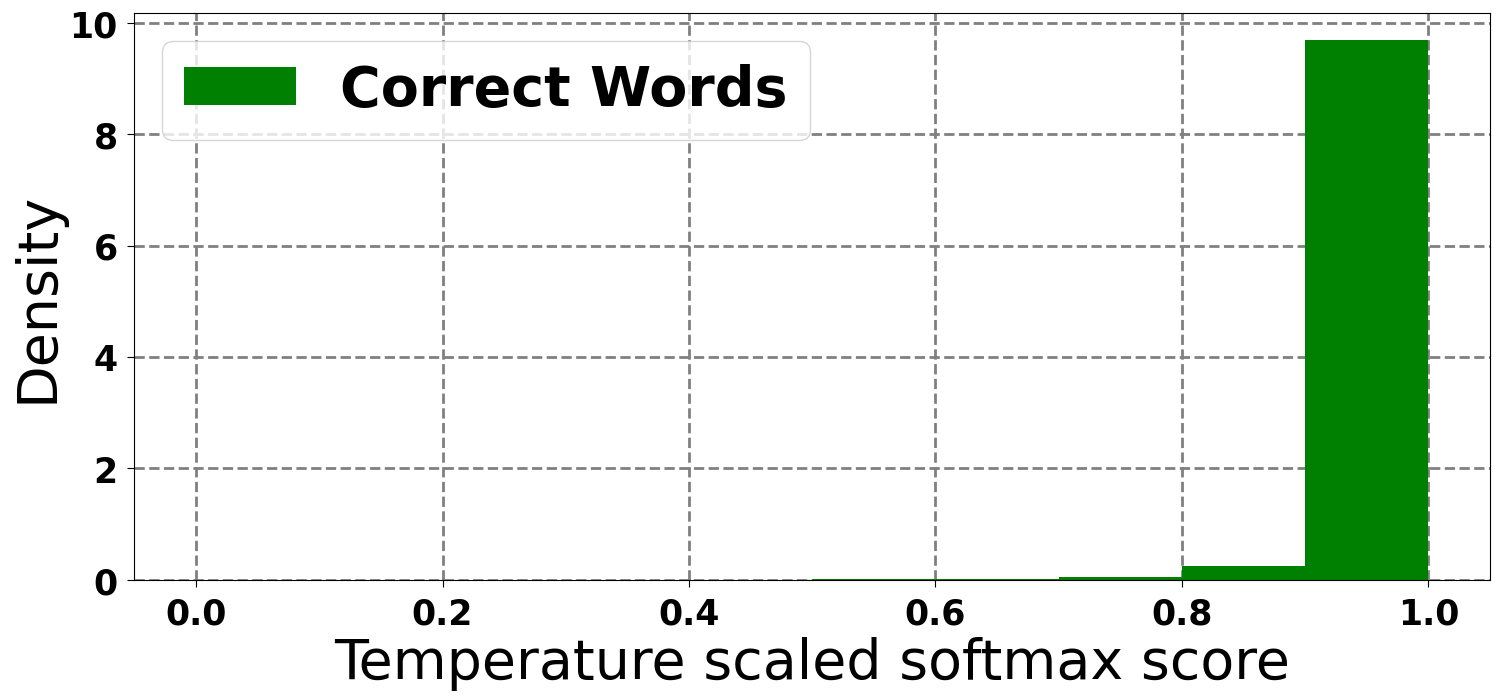

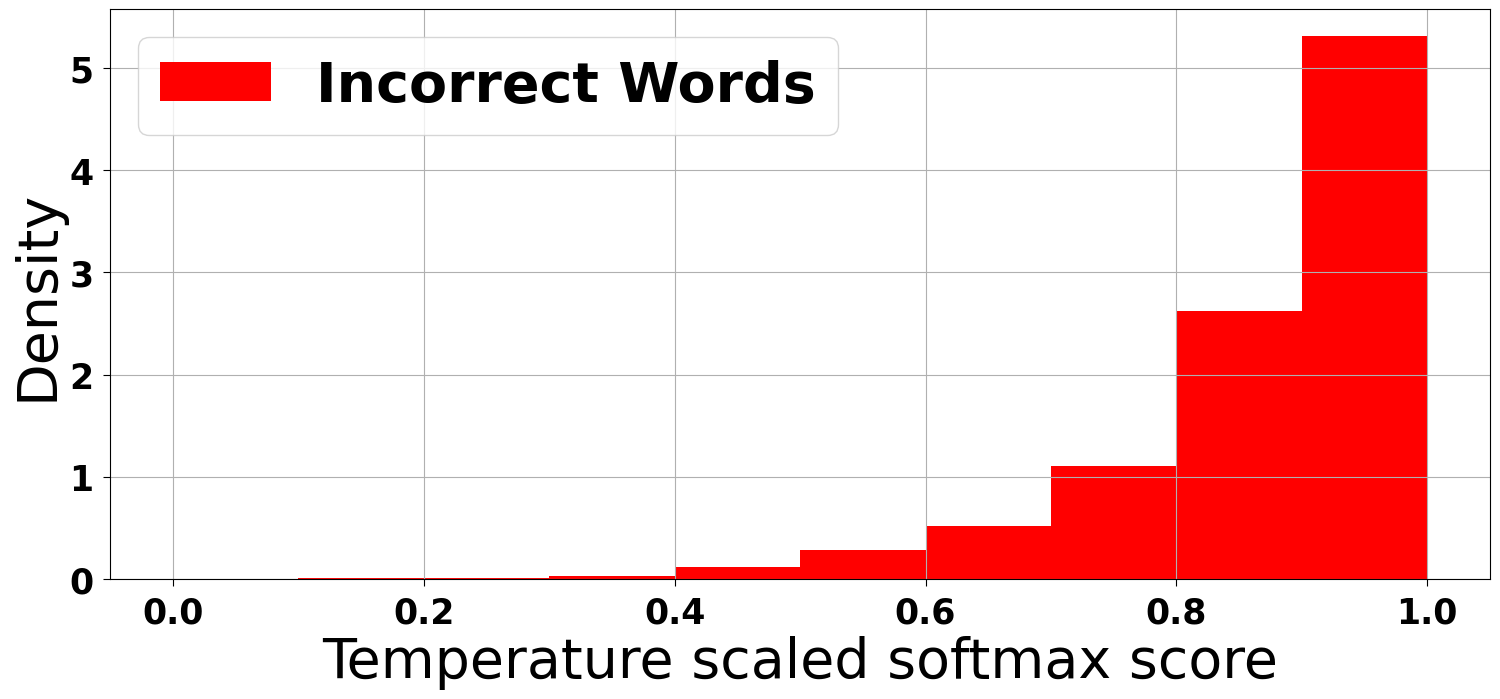

In [16]:
plot_histograms(y_score_correct, y_score_incorrect, x_label_name="Temperature scaled softmax score")

In [17]:
p = []

actual_score_all_one_list = []
for i in range(len(correct_marks)):
    
    for j in range(len(correct_marks[i])):
        p.append(targets_with_confidence[i][j][1])
        actual_score_all_one_list.append(actual_score_all[i][j])

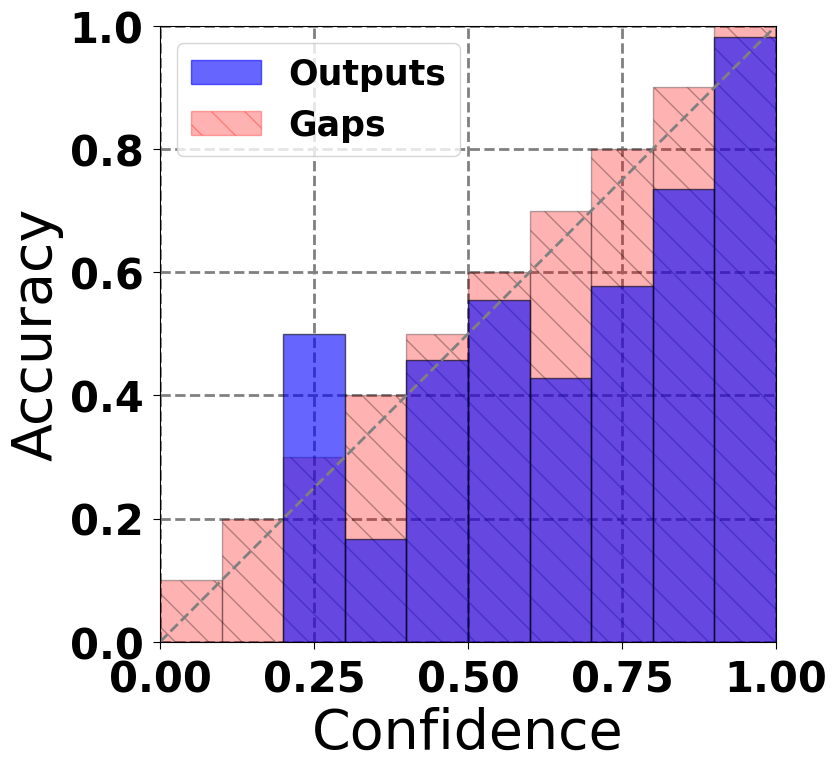

In [18]:
ece, mce = draw_reliability_graph(p, actual_score_all_one_list)

## Entropy based Confidence

In [19]:
targets_with_confidence = []
correct_marks = []
actual_score_all = [] 
except_count = 0
for batch in tqdm(input_testloader):
    # try:
    references, HYP, word_ops_list, entropy_score = mainf_entropy(batch, asr_model, DEVICE, TEST_BS, temperature = 0.33, aggregation_method='min')
    # except:
    #     except_count += 1
    empty = False


    for i in range(len(HYP)):
        if HYP[i] == '':
            empty = True
    target_temp = []
    correct_temp = []
    if empty == True:
        continue
    for i in range(len(HYP)):
        words = HYP[i].split()
        j = 0
        for word in words:
            target_temp.append((word, entropy_score[i][j]))
            j+=1
        targets_with_confidence.append(target_temp)
        for k in range(len(word_ops_list[i])):
            if word_ops_list[i][k] == 'D':
                continue
            if word_ops_list[i][k] == 'C':
                correct_temp.append(1)
            else:
                correct_temp.append(0)
        correct_marks.append(correct_temp)
        actual_score_all.append(correct_temp)

print("exception count:", except_count)

  0%|          | 0/2620 [00:00<?, ?it/s]

exception count: 0


In [20]:
y_true, y_score = np.array(
    [[f, p[1]] for cm, twc in zip(correct_marks, targets_with_confidence) for f, p in zip(cm, twc)]
).T

mask_correct = y_true == 1
y_score_correct = y_score[mask_correct]
y_score_incorrect = y_score[~mask_correct]

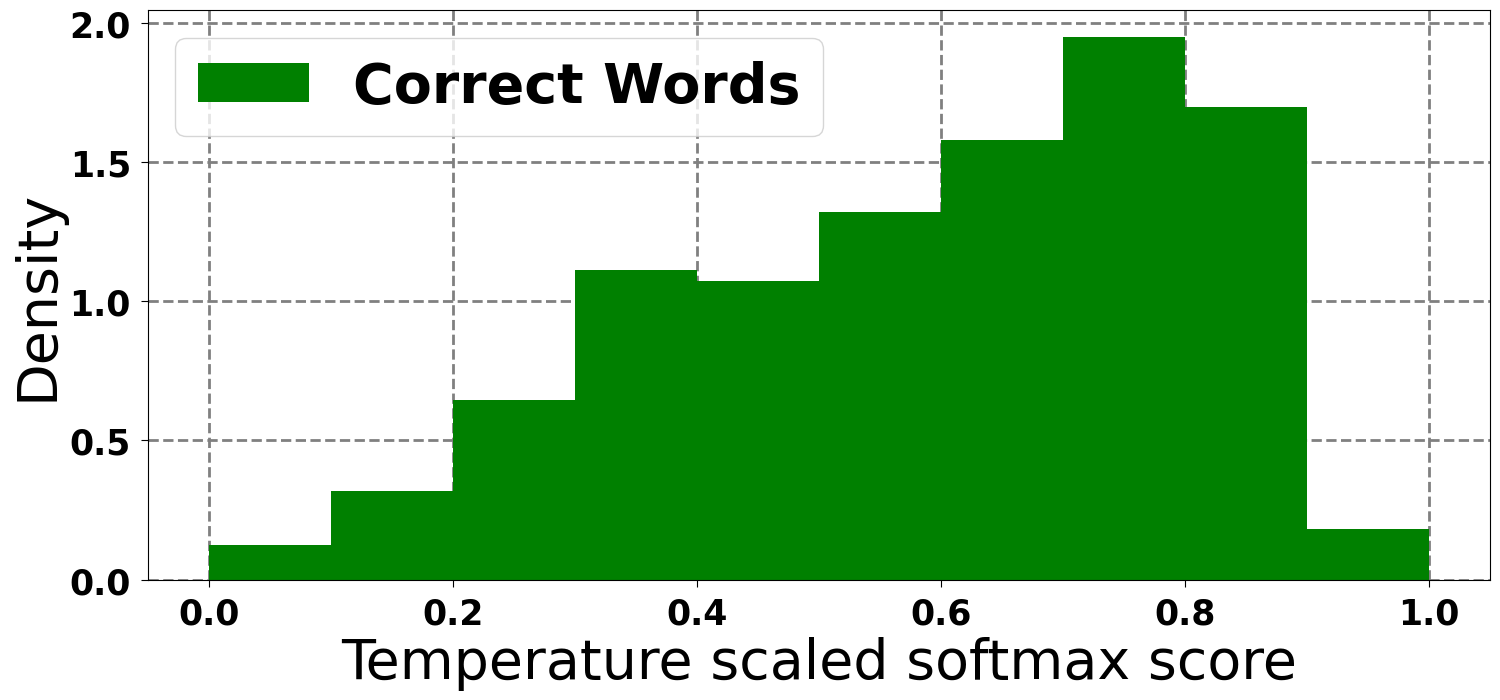

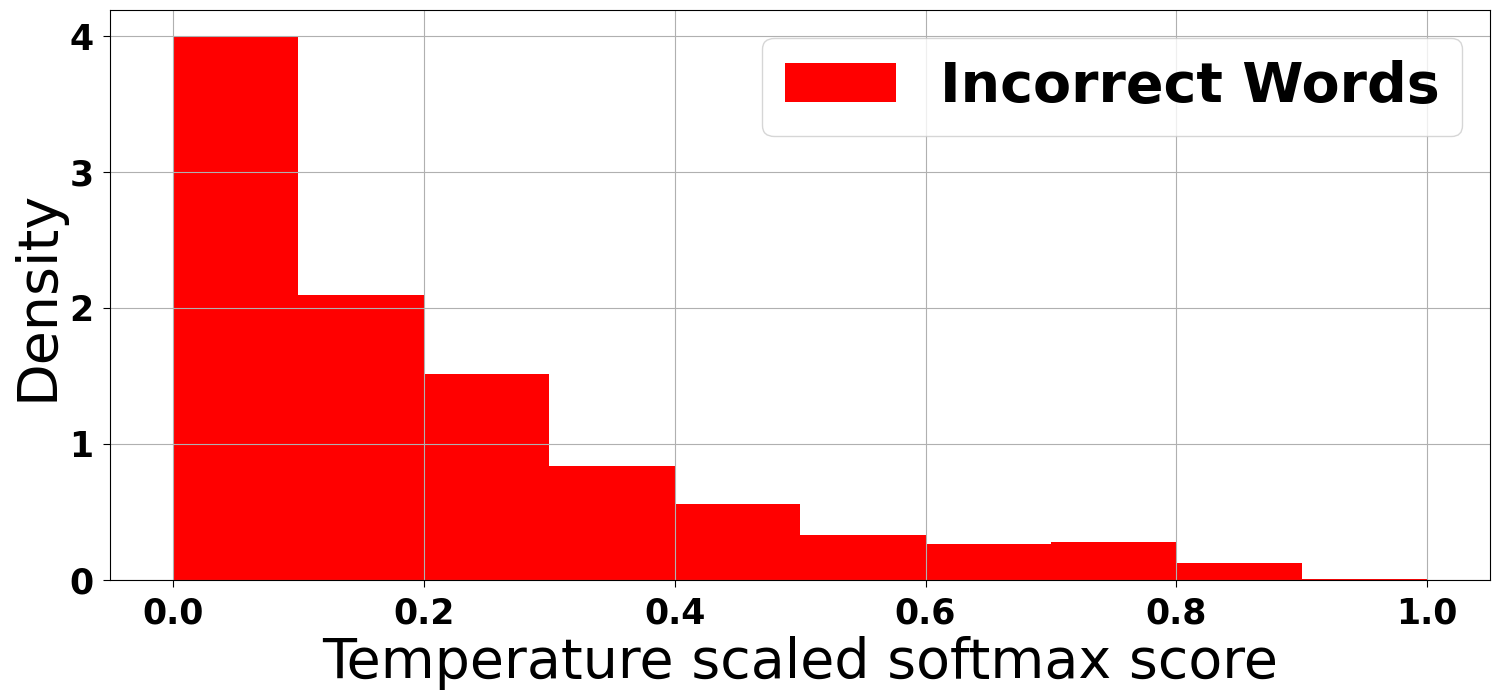

In [21]:
plot_histograms(y_score_correct, y_score_incorrect, x_label_name="Temperature scaled softmax score")

In [22]:
p = []

actual_score_all_one_list = []
for i in range(len(correct_marks)):
    
    for j in range(len(correct_marks[i])):
        p.append(targets_with_confidence[i][j][1])
        actual_score_all_one_list.append(actual_score_all[i][j])

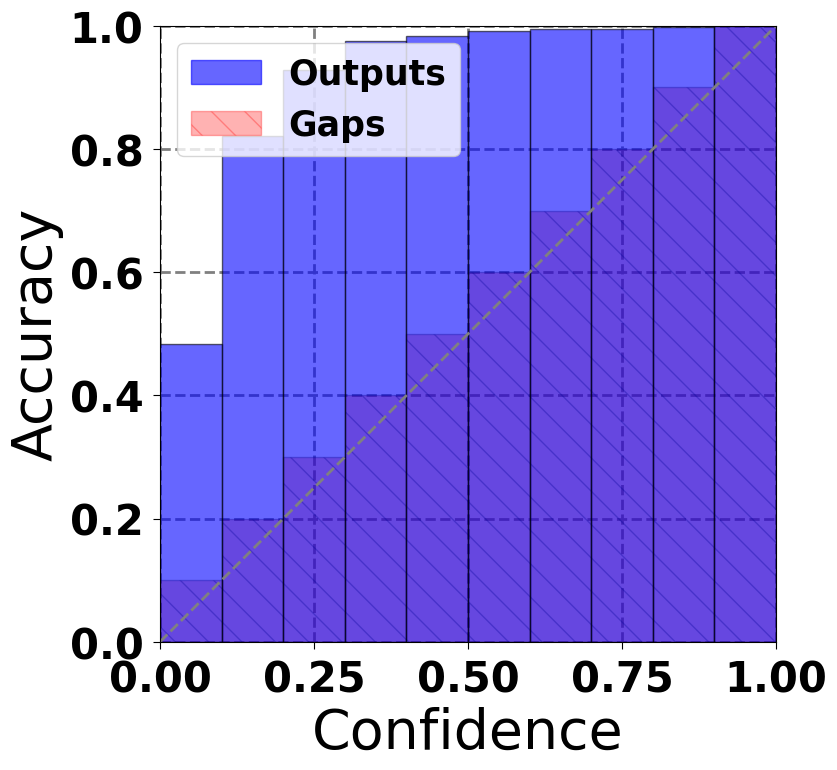

In [23]:
ece, mce = draw_reliability_graph(p, actual_score_all_one_list)

## TruCLeS

In [24]:
from trucles_model import trucles_linear_deep
from trucles_utils import load_checkpoint_confid, test_validate_trucles

In [25]:
confid_model_name = 'linear_deep'
loss = 'shrinkage'
TEST_BS = 1
input_dim = 434 #176-dmodel+129-decoder+129-word_piece
hidden_dim = 128
learning_rate = 0.001
audio_root = ""
alpha=2.0
beta=0.5

confid_checkpoint = "/home/thishyan/interspeech-2025/trucles_interspeech/ctc/best_confid_small_ls.pt"

# Load SentencePiece model
spm_model_path = "/home/thishyan/interspeech-2025/stt_en_conformer_ctc_small_ls_tokenizer.model"

In [26]:
asr_model.freeze() # inference mode
asr_model = asr_model.to(DEVICE) # transfer model to device
asr_model.decoder.vocabulary

blank = len(asr_model.decoder.vocabulary)
unkwn = 0
vocab = copy.deepcopy(asr_model.decoder.vocabulary)
vocab.append('@')

sp = spm.SentencePieceProcessor()
sp.load(spm_model_path)

confid_model = trucles_linear_deep(input_dim=input_dim, hidden_dim=hidden_dim).to(DEVICE)

In [27]:
load_checkpoint_confid(confid_model, confid_checkpoint, DEVICE)

(17, 0.019881574765356166)

In [28]:
preds_with_confidence = []
correct_marks = []
actual_score_all = [] 
for batch in tqdm(input_testloader):
    references, HYP, word_ops_list, actual_score, score = test_validate_trucles(confid_model, batch, asr_model, DEVICE, TEST_BS, vocab, sp)
    empty = False
    for i in range(len(HYP)):
        if HYP[i] == '':
            empty = True
    target_temp = []
    correct_temp = []
    if empty == True:
        continue
    for i in range(len(HYP)):
        words = HYP[i].split()
        j = 0
        for word in words:
            target_temp.append((word, score[j]))
            j+=1
        preds_with_confidence.append(target_temp)
        for k in range(len(word_ops_list[i])):
            if word_ops_list[i][k] == 'D':
                continue
            if word_ops_list[i][k] == 'C':
                correct_temp.append(True)
            else:
                correct_temp.append(False)
        correct_marks.append(correct_temp)
        actual_score_all.append(actual_score[i])

  0%|          | 0/2620 [00:00<?, ?it/s]

In [29]:
y_true, y_score = np.array(
    [[f, p] for cm, twc in zip(correct_marks, actual_score_all) for f, p in zip(cm, twc)]
).T

mask_correct = y_true == 1
y_score_correct = y_score[mask_correct]
y_score_incorrect = y_score[~mask_correct]

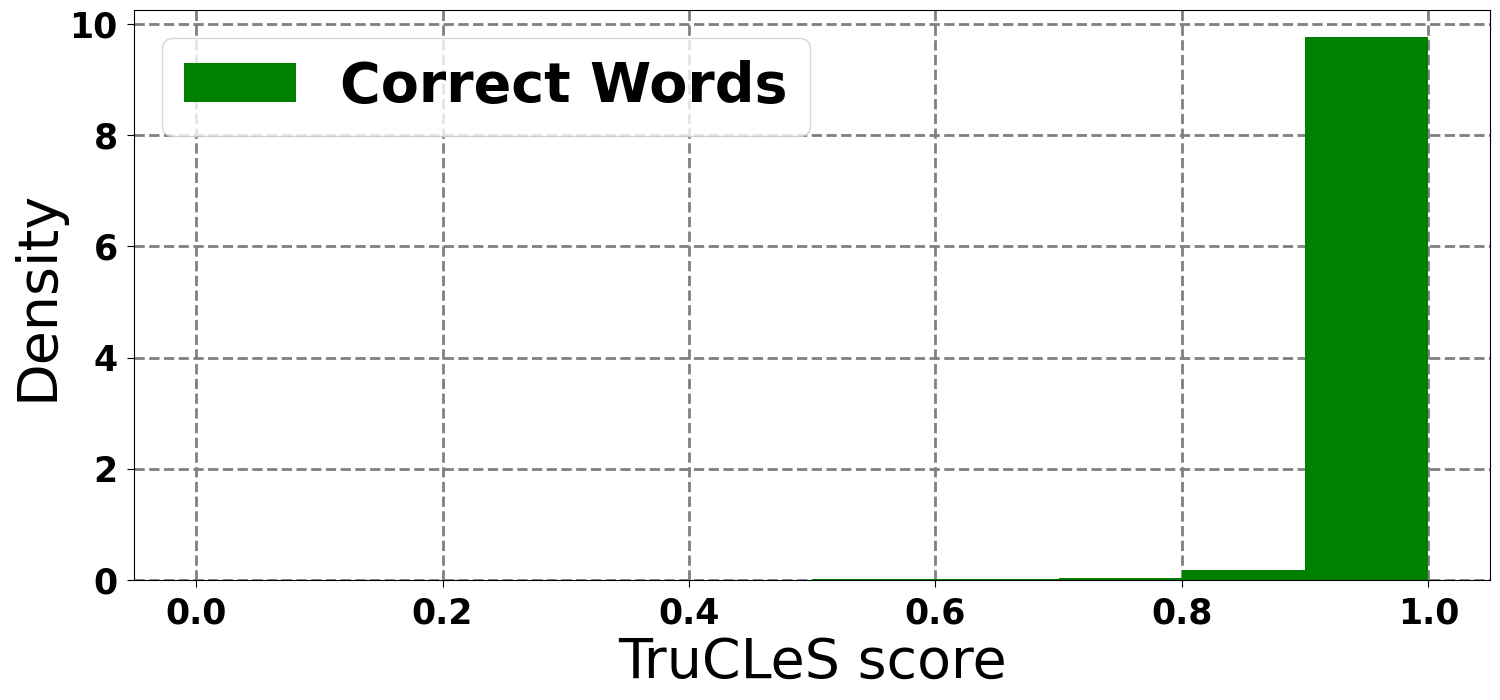

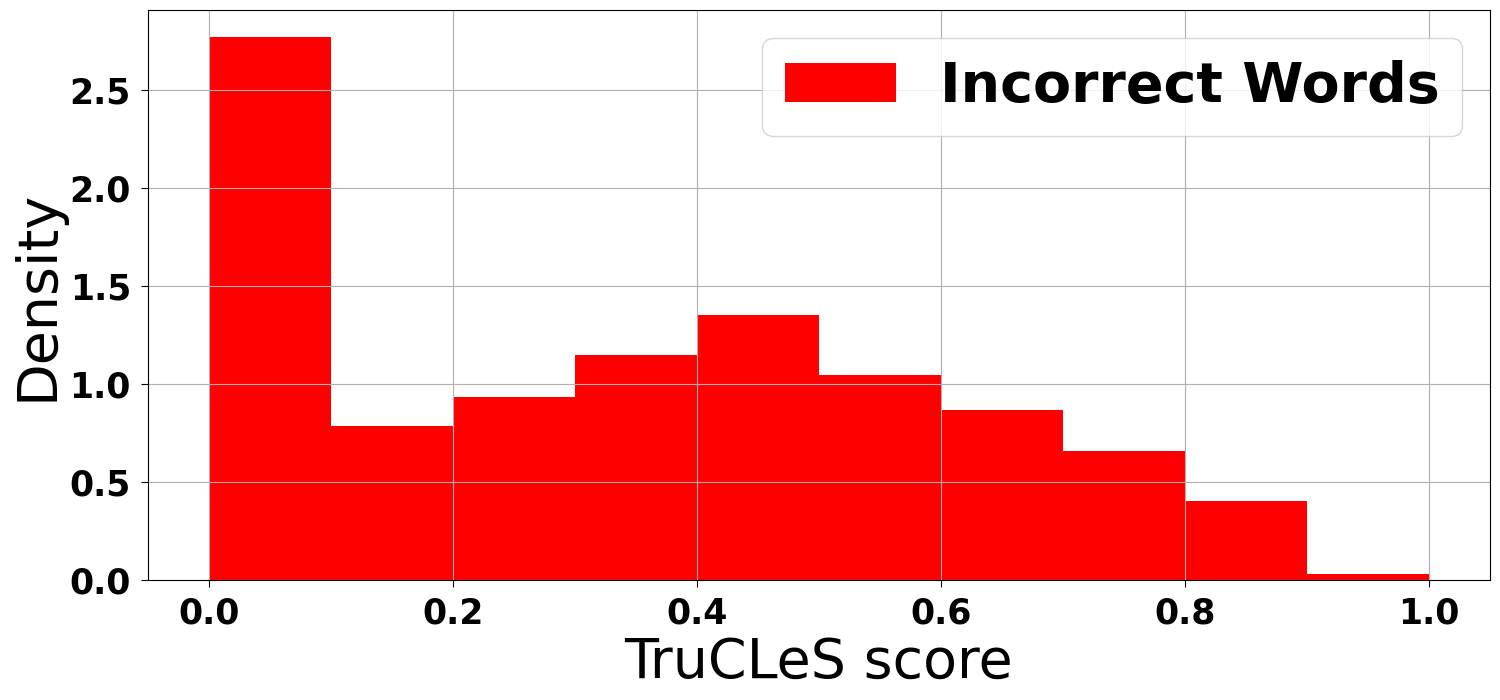

In [30]:
plot_histograms(y_score_correct, y_score_incorrect, x_label_name="TruCLeS score")

In [31]:
a = []
p = []
a_list = []
p_list = []
correct_marks_in_one_list = []

for i in range(len(correct_marks)):
    temp_a = []
    temp_p = []
    for j in range(len(correct_marks[i])):
        if correct_marks[i][j] == True:
            a.append(1)
            temp_a.append(1)
        else:
            a.append(0)
            temp_a.append(0)
        correct_marks_in_one_list.append(correct_marks[i][j])
        p.append(preds_with_confidence[i][j][1])
        temp_p.append(preds_with_confidence[i][j][1])
    a_list.append(temp_a)
    p_list.append(temp_p)

actual = torch.tensor(correct_marks_in_one_list)
pred = torch.tensor(p)

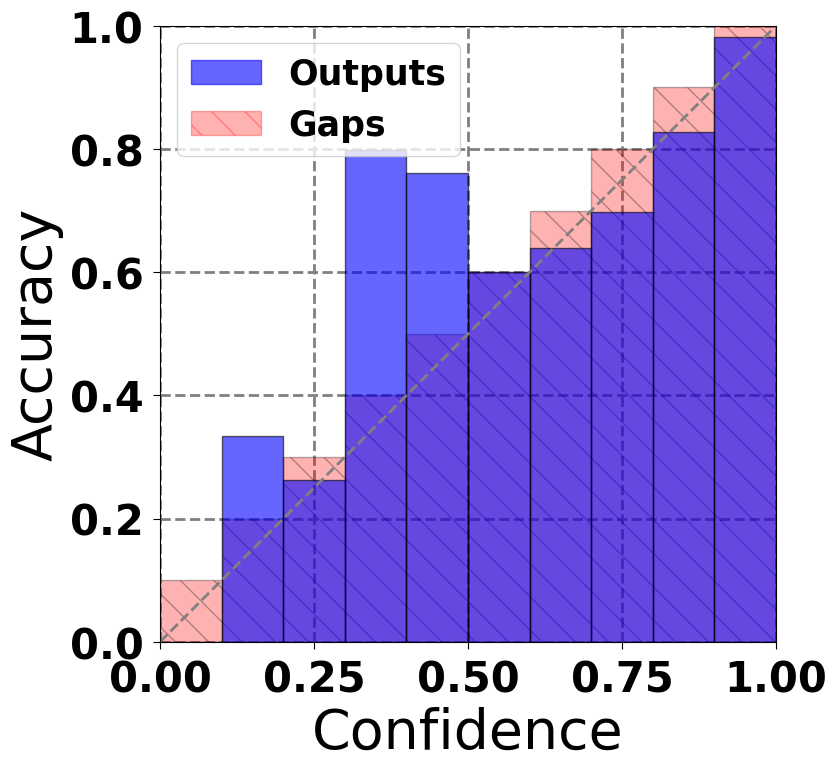

In [32]:
ece, mce = draw_reliability_graph(p, correct_marks_in_one_list)